# Regression example: *Synthetic* 1 dataset


$$y  = 5x_1-5x_2$$




## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import EarlyStopping,LRScheduler,Checkpoint, TrainEndCheckpoint, EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split

In [6]:
sys.path.append("../")
from sramodels.SRAModels import TabSRALinearClassifier,InputShapeSetterTabSRA,LinearRegressor

In [7]:
from interpret.glassbox import ExplainableBoostingRegressor


In [8]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
set_visualize_provider(InlineProvider())

## Data

In [9]:
np.random.seed(42)
x1 = np.random.normal(0,1,3*10000)
x2 = np.random.normal(0,1,3*10000)
x3 = np.random.normal(0,1,3*10000)
x4 = np.random.normal(0,1,3*10000)
x5 = np.random.normal(0,1,3*10000)
X = np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1)  ),axis=1)

In [10]:
odd = 5*x1-5*x2
y_c = 1/(1+np.exp(-odd))
y = np.where(y_c>0.5, 1,0)
X_train_,X_test_,Y_train_,Y_test_ = train_test_split(X,odd,stratify =y , random_state=42)
n_features, n_classes = 5,1
len(Y_train_),len(Y_test_)

(22500, 7500)

In [11]:
feature_names = ['x1','x2','x3','x4','x5']
X_train_ = pd.DataFrame(X_train_,columns=feature_names)
X_train_.head()

,x1,x2,x3,x4,x5
0,0.018047,1.384203,0.062076,0.594253,0.262809
1,0.204798,1.277262,-0.662040,-0.095000,0.267240
2,0.895193,1.600402,1.595708,-0.980847,1.745891
3,-0.447961,-2.337672,-2.001379,-1.112750,-0.038264
4,0.790626,0.661318,0.845630,2.040630,1.260280


In [12]:
X_test_ = pd.DataFrame(X_test_,columns=feature_names)
X_test_.head()

,x1,x2,x3,x4,x5
0,1.987276,1.177705,-0.248466,-0.644142,-0.890501
1,0.997266,-0.694594,-0.447051,-0.581979,-0.214629
2,1.447306,1.030847,-0.796111,0.923338,-0.852372
3,-1.333432,-0.780459,-1.403931,0.402760,0.597125
4,-0.467701,-2.232282,0.954899,-0.952536,0.014282


In [13]:
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.reshape(-1,1).astype(np.float32))

## Model: LR (Linear Regression)

In [14]:
other_params_linear = {"module__bias":True,
                "optimizer__lr":0.5*1e-2,
                "optimizer__weight_decay":0.0,
                "random_state":42,
                "max_epochs":150,
                "batch_size":256,
                "device":'cuda'
               }
scoring = EpochScoring(scoring='r2',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=True)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=20,load_best=True,lower_is_better=False, threshold=0.00001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=10, min_lr=2e-5,factor=0.2, verbose=1,monitor='valid_loss', mode='min')
call_b = [scoring, setter, early_stop, lr_scheduler]

In [15]:
%%time
LR = LinearRegressor(**other_params_linear,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = LR.fit(X_train_.values.astype(np.float32),Y_train_.reshape(-1,1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch      r2    train_loss    valid_loss     dur
-------  ------  ------------  ------------  ------
      1  0.0659       51.9761       45.7299  0.5905
      2  0.2190       43.6184       38.2348  0.1660
      3  0.3518       36.3358       31.7329  0.1680
      4  0.4669       30.0067       26.0983  0.1752
      5  0.5660       24.5592       21.2468  0.1761
      6  0.6502       19.9046       17.1260  0.1604
      7  0.7210       15.9657       13.6570  0.1665
      8  0.7801       12.6643       10.7672  0.1624
      9  0.8286        9.9243        8.3898  0.1748
     10  0.8684        7.6789        6.4443  0.1604
     11  0.9003        5.8587        4.8811  0.1751
     12  0.9256        4.4065        3.6446  0.1667
     13  0.9453        3.2634        2.6760  0.1670
     14  0.9605        2.3772        1.9321  0.1668
     1

In [16]:
Coef  = pd.DataFrame(LR.get_weights()[0])
Coef = Coef
Coef.columns=feature_names
Coef

,x1,x2,x3,x4,x5
0,4.990098,-4.980789,-0.000333,0.000263,-0.000434


In [17]:
pred_tab_lr = LR.predict(X_test_.values.astype(np.float32))
rmse = np.sqrt(mean_squared_error(Y_test_, pred_tab_lr))
r2 = r2_score(Y_test_, pred_tab_lr) 
print(f"--RMSE perf = {rmse} -- r2 perf = {r2}")

--RMSE perf = 0.02154527170150907 -- r2 perf = 0.9999905182418856


## Model: TabSRALinear 

In [18]:
#valid_loss
other_params = {"module__encoder_bias":True,
                "module__classifier_bias":True,
                "module__n_hidden_encoder":1,
                "module__dim_head":4,
                "optimizer__lr":0.01,
                "max_epochs":150,
                "batch_size":256,                
                "optimizer__weight_decay":0,
                "random_state":42,
               }
scoring = EpochScoring(scoring='r2',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=True)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=20,load_best=True,lower_is_better=False, threshold=0.00001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=15, min_lr=2e-5,factor=0.2, verbose=1, mode='max',monitor=scoring.scoring)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [19]:
%%time
TabSRA = TabSRALinearRegressor(**other_params,callbacks=call_b,train_split = predefined_split(valid_dataset))
_ = TabSRA.fit(X_train_.values.astype(np.float32),Y_train_.reshape(-1,1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch      r2    train_loss    valid_loss     dur
-------  ------  ------------  ------------  ------
      1  0.3938       42.0372       29.6776  0.2631
      2  0.7929       19.9906       10.1408  0.2500
      3  0.9029        7.5711        4.7554  0.2507
      4  0.9479        3.7896        2.5519  0.2493
      5  0.9696        2.1007        1.4903  0.2504
      6  0.9812        1.2458        0.9185  0.2508
      7  0.9880        0.7754        0.5862  0.2498
      8  0.9921        0.4985        0.3863  0.2519
      9  0.9946        0.3305        0.2623  0.2514
     10  0.9962        0.2260        0.1837  0.2490
     11  0.9973        0.1591        0.1317  0.2489
     12  0.9980        0.1142        0.0957  0.2503
     13  0.9986        0.0833        0.0709  0.2503
     14  0.9989        0.0618        0.0526  0.2502
     1

In [20]:
Coef  = pd.DataFrame(TabSRA.get_weights()[0])
#Coef = Coef.T
Coef.columns=feature_names
Coef

,x1,x2,x3,x4,x5
0,4.999671,-4.994568,-2.530221,-2.971298,2.85088


In [21]:
pred_tabsra = TabSRA.predict(X_test_.values.astype(np.float32))

rmse_tabsra = np.sqrt(mean_squared_error(Y_test_, pred_tabsra))
r2_tabsra = r2_score(Y_test_, pred_tabsra) 
print(f"--RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")

--RMSE perf = 0.00967252000535716 -- r2 perf = 0.999998088984565


## Model: EBM_S & EBM

In [22]:
%%time
EBM_S = ExplainableBoostingRegressor(interactions=0,max_rounds=2500,early_stopping_rounds=50,validation_size=0)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM_S.fit(X_train_, Y_train_)

/home/kodjo/anaconda3/lib/python3.9/site-packages/interpret/glassbox/_ebm/_ebm.py:426: UserWarning: If validation_size is 0, the outer_bags have no purpose. Set outer_bags=1 to remove this warning.
  warn(


CPU times: user 466 ms, sys: 252 ms, total: 718 ms
Wall time: 2.13 s


ExplainableBoostingRegressor(interactions=0, max_rounds=2500, validation_size=0)

In [23]:
pred_EBM_S = EBM_S.predict(X_test_)

rmse_ebm_s = np.sqrt(mean_squared_error(Y_test_, pred_EBM_S))
r2_ebm_s = r2_score(Y_test_, pred_EBM_S) 
print(f"--RMSE perf = {rmse_ebm_s} -- r2 perf = {r2_ebm_s}")

--RMSE perf = 0.23282405622480565 -- r2 perf = 0.9988927629134866


In [24]:
#show(EBM_S.explain_global())

In [25]:
%%time
EBM = ExplainableBoostingRegressor(interactions=4,max_rounds=2500,early_stopping_rounds=50,validation_size=0)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM.fit(X_train_, Y_train_)

/home/kodjo/anaconda3/lib/python3.9/site-packages/interpret/glassbox/_ebm/_ebm.py:426: UserWarning: If validation_size is 0, the outer_bags have no purpose. Set outer_bags=1 to remove this warning.
  warn(


CPU times: user 193 ms, sys: 4.08 ms, total: 197 ms
Wall time: 2.79 s


ExplainableBoostingRegressor(interactions=4, max_rounds=2500, validation_size=0)

In [26]:
pred_EBM = EBM.predict(X_test_)

rmse_ebm = np.sqrt(mean_squared_error(Y_test_, pred_EBM))
r2_ebm = r2_score(Y_test_, pred_EBM) 
print(f"--RMSE perf = {rmse_ebm} -- r2 perf = {r2_ebm}")

--RMSE perf = 0.23382377707941246 -- r2 perf = 0.998883233790613


In [27]:
#show(EBM.explain_global(name=feature_names))

## Model: XGBoost 

In [28]:
from xgboost import XGBRegressor


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [29]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBRegressor(**config_opt)
    return model_xgb

In [30]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.03425616464106714,
              'max_depth': 5,
              'colsample_bytree': 1.0,
              'subsample': 1.0,
              'n_estimators': 1100,
              'min_child_weight':56

              }
static_params_xgb = {
                 'random_state':45,
                 'n_jobs': -1,
}


In [31]:
%%time
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_)]
model_xgb.fit(X_train_, Y_train_, eval_metric=['rmse'], eval_set=eval_set, verbose=0)

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 57.1 s, sys: 38.9 s, total: 1min 36s
Wall time: 6.04 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             eta=0.03425616464106714, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.034256164,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=1100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict(X_test_)
best_rmse_xgb = np.sqrt(mean_squared_error(Y_test_, pred_xgboost) )
best_r2_xgb = r2_score(Y_test_, pred_xgboost) 
print(f"--RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")

--RMSE perf = 0.24291824682524243 -- r2 perf = 0.998794672132331


## Interpretability: using feature attribution on the test data

- For Linear Regression, the effect is given by $\beta\odot x$ where $\beta$ is the regression coefficients.
- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the SRA attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [33]:
%%time
attributions_linear = pd.DataFrame(LR.get_feature_attribution(X_test_.values))
attributions_linear.columns = feature_names
attributions_linear['pred_proba'] = pred_tab_lr
attributions_linear['label'] = Y_test_

CPU times: user 93 ms, sys: 116 ms, total: 209 ms
Wall time: 14.7 ms


In [34]:
%%time
attributions_tabsra = pd.DataFrame(TabSRA.get_feature_attribution(X_test_.values))
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra
attributions_tabsra['label'] = Y_test_

CPU times: user 20.1 ms, sys: 26.1 ms, total: 46.2 ms
Wall time: 3.32 ms


In [35]:
def get_feature_attribution_EBM(model, X_test):
    tmp  = model.explain_local(X_test)
    df_EBM = []
    for i in range(len(X_test)):
        df_EBM.append(tmp.data(i)['scores'])
    df_EBM = pd.DataFrame(df_EBM)
    df_EBM.columns = tmp.data(0)['names']
    return df_EBM

In [36]:
%%time
attributions_EBM_S = get_feature_attribution_EBM(EBM_S, X_test_)


CPU times: user 974 ms, sys: 1.37 s, total: 2.35 s
Wall time: 171 ms


In [37]:
%%time
attributions_EBM = get_feature_attribution_EBM(EBM, X_test_)


CPU times: user 100 ms, sys: 8.11 ms, total: 109 ms
Wall time: 108 ms


In [38]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred'] = pred_xgboost
attributions_xgb['label'] = Y_test_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 13.3 s, sys: 284 ms, total: 13.5 s
Wall time: 1.36 s


LR --RMSE perf = 0.02154527170150907 -- r2 perf = 0.9999905182418856


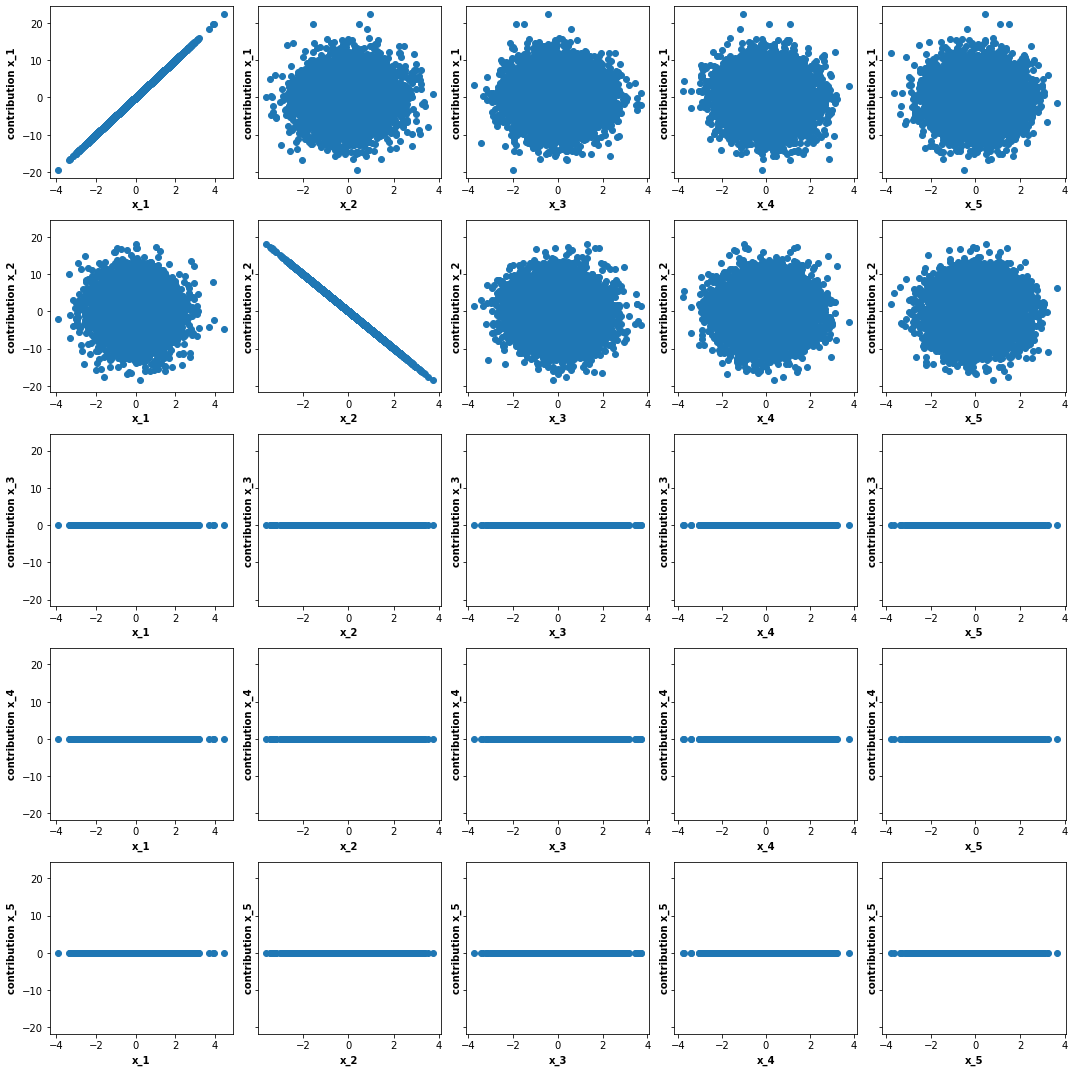

In [39]:
print(f"LR --RMSE perf = {rmse} -- r2 perf = {r2}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_linear[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

TabSRALinear --RMSE perf = 0.00967252000535716 -- r2 perf = 0.999998088984565


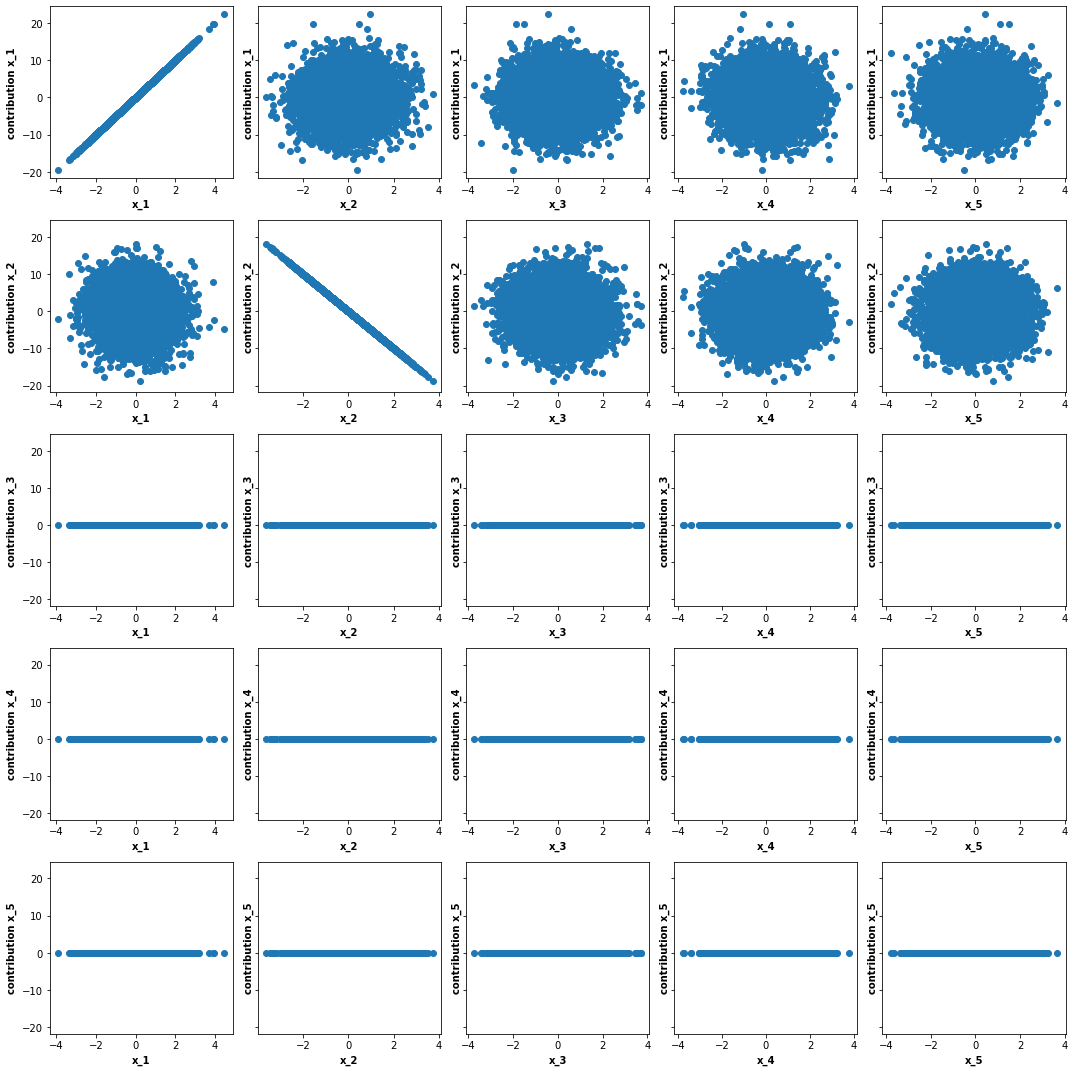

In [40]:
print(f"TabSRALinear --RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_tabsra[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

EBM_S --RMSE perf = 0.23282405622480565 -- r2 perf = 0.9988927629134866


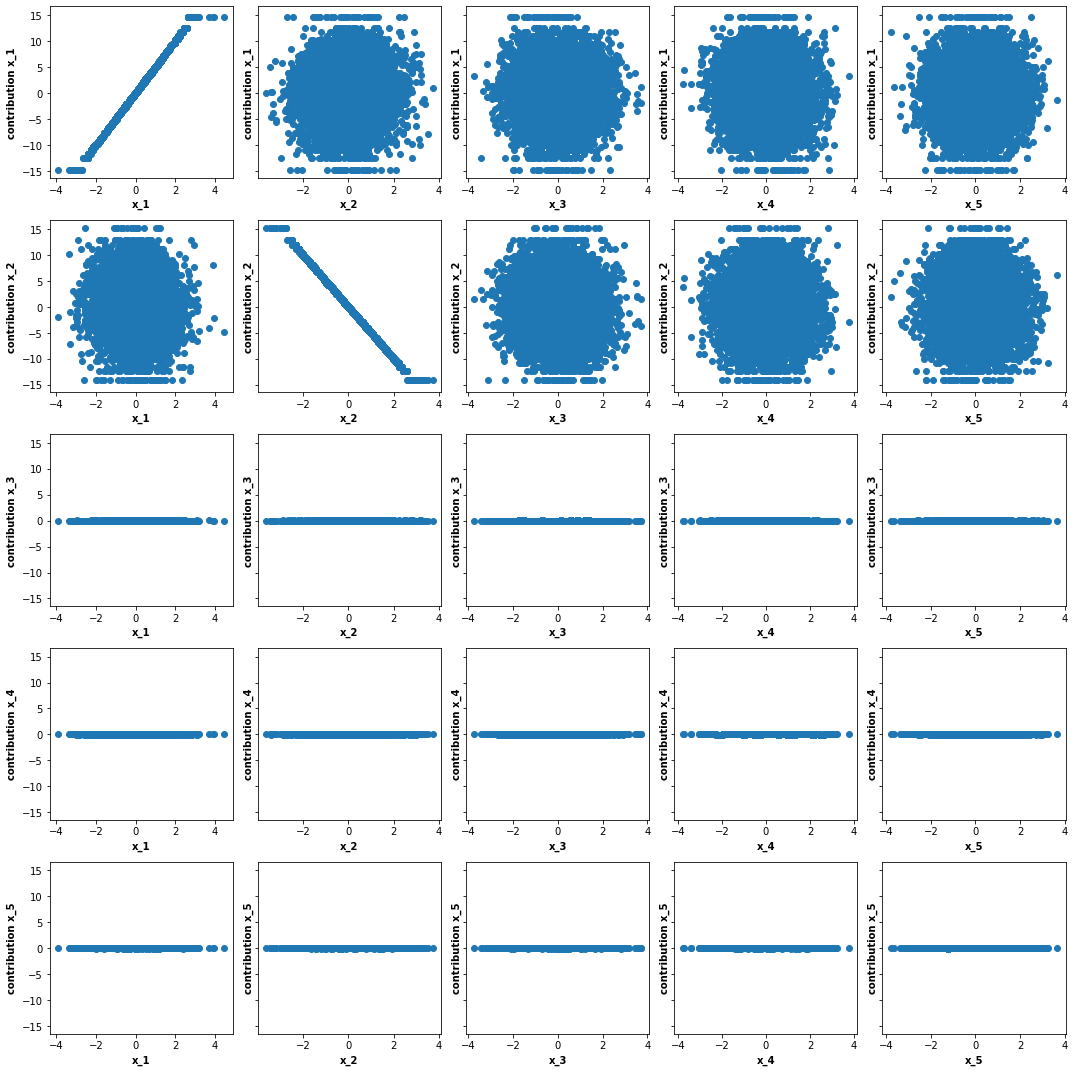

In [41]:
print(f"EBM_S --RMSE perf = {rmse_ebm_s} -- r2 perf = {r2_ebm_s}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_EBM_S[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

XGBoost --RMSE perf = 0.24291824682524243 -- r2 perf = 0.998794672132331


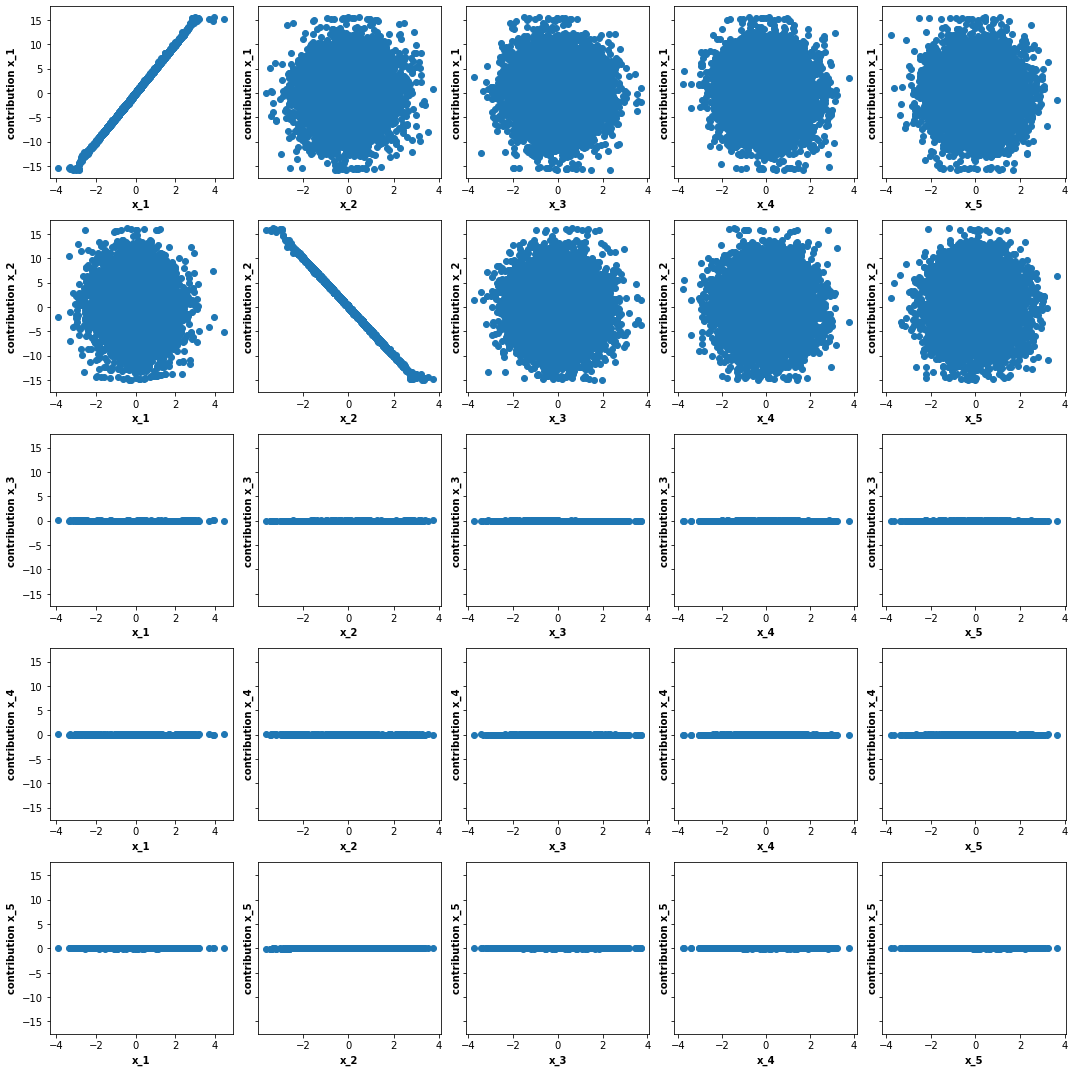

In [42]:
print(f"XGBoost --RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_xgb[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

## Identification of important features

We consider all the test set and only $x_1$ and $x_2$ are relevant among $(x_1, x_2, x_3, x_4, x_5)$. 
As the feature attributions (importances) of LR and TabSRALinear are a multiplicative function of the raw input, we choose at distance 0.05 from the origin (0.0) for fair comparison

In [43]:
condition = (X_test_.x1.abs()>0.05)&(X_test_.x2.abs()>0.05)
condition.sum()

6916

In [45]:
precision_lr = np.argsort(attributions_linear[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_lr.mean()/2

1.0

In [46]:
precision_tabsra = np.argsort(attributions_tabsra[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_tabsra.mean()/2

1.0

In [47]:
precision_ebm_s = np.argsort(attributions_EBM_S[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_ebm_s.mean()/2

1.0

In [48]:
precision_ebm = np.argsort(attributions_EBM[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_ebm.mean()/2

1.0

In [49]:
precision_xgb= np.argsort(attributions_xgb[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_xgb.mean()/2

1.0